This notebook will quantify how accurately different parameters of a CF-FM call can be measured by the ```measure_horseshoe_bat_calls``` package. 


### Stress-testing the package: how accurate is it really?

With the ```simulate_calls```  module of the package, there's a lot of flexibility in what kinds of calls can be simulated. Here let's run through a range of:

* Call durations
* CF properties : peak frequency, duration
* FM properties : terminal frequency (bandwidth), duration

We will *not* be testing more basic parameters such as rms or energy because it is assumed that if the call parts are segmented correctly, the rest of the parameters will be matched correctly too. 

In [1]:
%matplotlib notebook

In [51]:
import numpy as np 
import pandas as pd
import scipy.signal as signal 
import measure_horseshoe_bat_calls 
from measure_horseshoe_bat_calls.view_horseshoebat_call import *
from measure_horseshoe_bat_calls.simulate_calls import make_cffm_call
import measure_horseshoe_bat_calls.user_interface as ui

In [3]:
# Note the version of the package being run
measure_horseshoe_bat_calls.__version__

'1.9.9'

### An synthetic call example: 
Synthetic calls are the way to go in testing the accuracy of the package because we do not know *a priori* what the vocalisations of an animal call will be like, or what it should be like. Thus, the only way to convincingly test the performance of a tool like this is through simulation. 

In [4]:

call_parameters = {'cf':(100000, 0.01),
                    'upfm':(80000, 0.002),
                    'downfm':(60000, 0.003),
                    }

fs = 500*10**3 # 500kHz sampling rate
synthetic_call, freq_profile = make_cffm_call(call_parameters, fs)

# plot
wavef, spec = visualise_call(synthetic_call, fs, fft_size=512)
spec.set_ylim(0,125000)


<IPython.core.display.Javascript object>

(0, 125000)

### Test parameter space :

Let us now test the performance of the package with audio clips containing only a single call, with no noise or any silent background. This test run will quantify the call-part segmentation (CF-FM).

In [5]:
cf_durations = [0.002, 0.004, 0.008, 0.016, 0.032, 0.064]
cf_peakfreq = [40000, 60000, 90000]
fm_durations = [0.001, 0.002, 0.004]
fm_bw = [5000, 10000, 20000]

In [6]:
all_combinations = np.array(np.meshgrid(cf_peakfreq, cf_durations,
                                        fm_bw,fm_durations,
                                        np.flip(fm_bw),np.flip(fm_durations)))
all_params = all_combinations.flatten().reshape(6,-1).T

col_names = ['cf_peak_frequency', 'cf_duration',
             'upfm_bw', 'upfm_duration',
             'downfm_bw', 'downfm_duration']

parameter_space = pd.DataFrame(all_params, columns=col_names)
parameter_space['upfm_terminal_frequency'] = parameter_space['cf_peak_frequency'] - parameter_space['upfm_bw']
parameter_space['downfm_terminal_frequency'] = parameter_space['cf_peak_frequency'] - parameter_space['downfm_bw']

In [7]:
parameter_space

,cf_peak_frequency,cf_duration,upfm_bw,upfm_duration,downfm_bw,downfm_duration,upfm_terminal_frequency,downfm_terminal_frequency
0,40000.0,0.002,5000.0,0.001,20000.0,0.004,35000.0,20000.0
1,40000.0,0.002,5000.0,0.001,20000.0,0.002,35000.0,20000.0
2,40000.0,0.002,5000.0,0.001,20000.0,0.001,35000.0,20000.0
3,40000.0,0.002,5000.0,0.001,10000.0,0.004,35000.0,30000.0
4,40000.0,0.002,5000.0,0.001,10000.0,0.002,35000.0,30000.0
...,...,...,...,...,...,...,...,...
1453,90000.0,0.064,20000.0,0.004,10000.0,0.002,70000.0,80000.0
1454,90000.0,0.064,20000.0,0.004,10000.0,0.001,70000.0,80000.0
1455,90000.0,0.064,20000.0,0.004,5000.0,0.004,70000.0,85000.0
1456,90000.0,0.064,20000.0,0.004,5000.0,0.002,70000.0,85000.0


In [8]:
parameter_columns = ['cf_peak_frequency', 'cf_duration',
                     'upfm_terminal_frequency', 'upfm_duration',
                     'downfm_terminal_frequency', 'downfm_duration']

In [9]:
all_calls = {}
for row_number, parameters in parameter_space.iterrows():

    cf_peak, cf_durn, upfm_terminal, upfm_durn, downfm_terminal, downfm_durn = parameters[parameter_columns]
    call_parameters = {'cf':(cf_peak, cf_durn),
                        'upfm':(upfm_terminal, upfm_durn),
                        'downfm':(downfm_terminal, downfm_durn),
                        }

    fs = 500*10**3 # 500kHz sampling rate
    synthetic_call, _ = make_cffm_call(call_parameters, fs)
    synthetic_call *= signal.tukey(synthetic_call.size, 0.01)
    all_calls[row_number] = synthetic_call


In [10]:
parameter_space.shape

(1458, 8)

In [11]:
freq_resolution_columns = ['cf_peakfreq_resolution', 'downfm_terminalfreq_resolution',
                          'upfm_terminalfreq_resolution']

In [13]:
accuracy = parameter_space.copy()

In [18]:
for call_number in range(parameter_space.shape[0]):
    output = ui.segment_and_measure_call(all_calls[call_number], fs,
                                         peak_percentage=0.995)
    seg_output, call_parts, measurements, backg_output = output
    this_call_msmts = pd.DataFrame(measurements, index=[call_number])
    measurement_accuracy =  this_call_msmts.loc[:,parameter_columns]/parameter_space.loc[call_number,parameter_columns]
    accuracy.loc[call_number,parameter_columns] = measurement_accuracy.iloc[0,:]


KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

In [17]:
pd.DataFrame(measurements, index=[call_number])

,call_duration,call_energy,call_rms,peak_frequency,peak_frequency_resolution,cf_start,cf_end,cf_duration,cf_energy,cf_rms,cf_peak_frequency,cf_peakfreq_resolution,downfm_duration,downfm_energy,downfm_rms,downfm_terminal_frequency,downfm_terminalfreq_resolution,downfm_start,downfm_end,terminal_frequency_threshold
20,0.007,1738.559857,0.704792,40000.0,142.775557,0.003964,0.006064,0.002102,525.439847,0.707066,40437.678402,475.285171,0.000934,228.296806,0.699184,19271.948608,1070.663812,0.006066,0.006998,-10


In [37]:
parameter_columns

['cf_peak_frequency',
 'cf_duration',
 'upfm_terminal_frequency',
 'upfm_duration',
 'downfm_terminal_frequency',
 'downfm_duration']

In [41]:
parameter_space.iloc[20,:]

cf_peak_frequency            40000.000
cf_duration                      0.002
upfm_bw                       5000.000
upfm_duration                    0.004
downfm_bw                    20000.000
downfm_duration                  0.001
upfm_terminal_frequency      35000.000
downfm_terminal_frequency    20000.000
Name: 20, dtype: float64

In [39]:
this_call_msmts

,call_duration,call_energy,call_rms,peak_frequency,peak_frequency_resolution,cf_start,cf_end,cf_duration,cf_energy,cf_rms,cf_peak_frequency,cf_peakfreq_resolution,downfm_duration,downfm_energy,downfm_rms,downfm_terminal_frequency,downfm_terminalfreq_resolution,downfm_start,downfm_end,terminal_frequency_threshold
20,0.007,1738.559857,0.704792,40000.0,142.775557,0.003964,0.006064,0.002102,525.439847,0.707066,40437.678402,475.285171,0.000934,228.296806,0.699184,19271.948608,1070.663812,0.006066,0.006998,-10


<IPython.core.display.Javascript object>


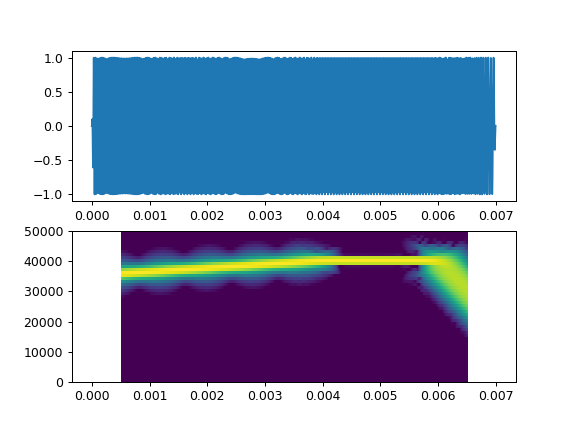

(0, 50000)

In [44]:
w,s = visualise_call(all_calls[20],fs)
s.set_ylim(0,50000)

In [68]:
call_number = 20
output = ui.segment_and_measure_call(all_calls[call_number], fs,
                                         peak_percentage=0.995)
seg_output, call_parts, measurements, backg_output = output


In [69]:
this_call_msmts = pd.DataFrame(measurements, index=[call_number])

In [70]:
this_call_msmts

,call_duration,call_energy,call_rms,peak_frequency,peak_frequency_resolution,cf_start,cf_end,cf_duration,cf_energy,cf_rms,cf_peak_frequency,cf_peakfreq_resolution,downfm_duration,downfm_energy,downfm_rms,downfm_terminal_frequency,downfm_terminalfreq_resolution,downfm_start,downfm_end,terminal_frequency_threshold
20,0.007,1738.559857,0.704792,40000.0,142.775557,0.003964,0.006064,0.002102,525.439847,0.707066,40437.678402,475.285171,0.000934,228.296806,0.699184,19271.948608,1070.663812,0.006066,0.006998,-10


In [63]:
cf, fm, _ = seg_output

<IPython.core.display.Javascript object>


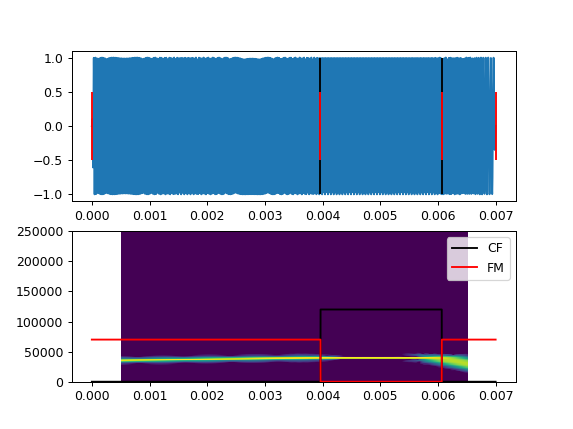

(<matplotlib.axes._subplots.AxesSubplot at 0x1fa5edc8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x201dbf88>)

In [64]:
check_call_parts_segmentation(all_calls[call_number], fs, cf,fm)

In [74]:
from measure_horseshoe_bat_calls.measure_a_horseshoe_bat_call import get_fm_snippets

In [75]:
fm_types, fm_sweeps, fm_startstop = get_fm_snippets(all_calls[call_number], fm, fs)

In [76]:
fm_types

['downfm_', 'downfm_']